# EPA1361 - Model-Based Decision Making

## Multi-model analysis

This exercise uses a simple version of the [Lotka-Volterra predator-prey equations](https://en.wikipedia.org/wiki/Lotka%E2%80%93Volterra_equations) to show how the EMA Workbench can be used for a
multi-model analysis, in addition to typical parametric/structural uncertainties. This will let you test the connectors provided in the Workbench for Excel, NetLogo, and Vensim / PySD; we'll also use the models for the sensitivity analysis exercise in week 3.

* Using the three model files provided and the Python function below, define model objects for each implementation (Excel, NetLogo, Vensim/PySD, and Python), and test them using a single ensemble. Use 50 experiments sampled from the parameters below (so that each experiment will be executed for the 4 models, for a total of 200), and retrieve outputs for the _TIME_, _predators_, and _prey_ variables.
    * excel and vensim are only supported on windows
    * vensim requires 32 bit python, and a 7.1!! version of vensim DSS
    * Netlogo supoprt depends on [jpype](http://jpype.readthedocs.io/en/latest/install.html) and [pynetlogo](https://pynetlogo.readthedocs.io/en/latest/). Also, if you don't have NetLogo installed, please get it from [NetLogo 6.0](https://ccl.northwestern.edu/netlogo/download.shtml) 
    * for pysd, see [its documentation](http://pysd.readthedocs.io/en/master/installation.html)
    * If possible try to work with all model versions, but even 2 or 3 (pure python and something else should be sufficient).
    

|Parameter	|Range or value	        |
|-----------|--------------:|
|prey_birth_rate    	|0.015 – 0.035	|
|predation_rate|0.0005 – 0.003 	|
|predator_efficiency     	|0.001 – 0.004	    |
|predator_loss_rate	    |0.04 – 0.08	    |
|Final time	    |365	    |
|dt	    |0.25	    |

* Note that your EMA Workbench installation includes example scripts for the different connectors. The different model objects follow a similar syntax but will need to be slightly adjusted depending on the software (e.g. to specify the NetLogo run length or the sheet name in Excel). 

* These model objects can be used with a replication functionality (for instance to test the effect of stochastic uncertainty in a NetLogo model), which repeats a given experiment over multiple replications. You can use a single replication in this exercise as the models are not stochastic. By default, each outcome array will then have a shape of (# experiments, # replications, # time steps). Try adapting the outcome arrays so that they can be used with the _lines_ plotting function of the Workbench, and plot the results grouped by model.

* To check the graphical results, find the maximum absolute error of the time series you obtained for the _prey_ variable in the Excel, NetLogo, and Vensim/PySD models, relative to the Python function. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from ema_workbench import (Model, RealParameter, TimeSeriesOutcome, perform_experiments,
                           ema_logging)

from ema_workbench.connectors.netlogo import NetLogoModel
from ema_workbench.connectors.excel import ExcelModel
from ema_workbench.connectors.pysd_connector import PysdModel

from ema_workbench.em_framework.evaluators import LHS, SOBOL, MORRIS

from ema_workbench.analysis.plotting import lines, Density


/usr/local/lib/python3.7/site-packages/ema_workbench/connectors/__init__.py:17: ImportWarning: vensim connector not available
  warnings.warn("vensim connector not available", ImportWarning)
/usr/local/Cellar/python/3.7.3/Frameworks/Python.framework/Versions/3.7/lib/python3.7/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/usr/local/lib/python3.7/site-packages/ema_workbench/analysis/prim.py:31: ImportWarning: altair based interactive inspection not available
  "inspection not available"), ImportWarning)
/usr/local/Cellar/python/3.7.3/Frameworks/Python.framework/Versions/3.7/lib/python3.7/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/usr/local/Cellar/python/3.7.3/Frameworks/Python.framework/Versions/3.7/lib/python3.7/importlib/_bootstrap.py:219: ImportWarning: ca

In [2]:
def PredPrey(prey_birth_rate=0.025, predation_rate=0.0015, predator_efficiency=0.002,
             predator_loss_rate=0.06, initial_prey=50, initial_predators=20, dt=0.25, final_time=365, reps=1):

    # Initial values
    predators, prey, sim_time = [np.zeros((reps, int(final_time/dt)+1)) for _ in range(3)]
    
    for r in range(reps):
        predators[r,0] = initial_predators
        prey[r,0] = initial_prey

        # Calculate the time series
        for t in range(0, sim_time.shape[1]-1):

            dx = (prey_birth_rate*prey[r,t]) - (predation_rate*prey[r,t]*predators[r,t])
            dy = (predator_efficiency*predators[r,t]*prey[r,t]) - (predator_loss_rate*predators[r,t])

            prey[r,t+1] = max(prey[r,t] + dx*dt, 0)
            predators[r,t+1] = max(predators[r,t] + dy*dt, 0)
            sim_time[r,t+1] = (t+1)*dt
    
    # Return outcomes
    return {'TIME':sim_time,
            'predators':predators,
            'prey':prey}

---

In [3]:
uncertainties =  [RealParameter('prey_birth_rate', 0.015, 0.035),
                   RealParameter('predation_rate', 0.0005, 0.003),
                   RealParameter('predator_efficiency', 0.001, 0.004),
                   RealParameter('predator_loss_rate', 0.04, 0.08)]

# final_time and dt already set correctly in PredPrey() by default
# there's another way to declare constants – see Jan's documentation
# final_time = 365
# dt = 0.25

outcomes = [TimeSeriesOutcome('TIME'),
              TimeSeriesOutcome('predators'),
              TimeSeriesOutcome('prey')]

nr_experiments = 50

## My Python work
Define model objects. Use 50 experiments sampled from the parameters below (so that each experiment will be executed for the 4 models, for a total of 200), and retrieve outputs for the TIME, predators, and prey variables.

In [4]:
modelPython = Model('PPfunPython', function= PredPrey) # How do we link multiple models together? How does this var work?
modelPython.uncertainties = uncertainties
modelPython.outcomes = outcomes

## PySD

In [5]:
modelPySD = PysdModel(name = 'PySD', mdl_file = 'model/PredPrey.mdl')
modelPySD.uncertainties = uncertainties
modelPySD.outcomes = outcomes

## NetLogo

Oops, I don't have Java installed.

In [6]:
# modelNetLogo = NetLogoModel('NetLogo', wd = '.', model_file = 'model/PredPrey.nlogo')
# modelNetLogo.uncertainties = uncertainties
# modelNetLogo.outcomes = outcomes

## Excel

Only works on Windows?

In [7]:
# modelExcel = ExcelModel('Excel', wd = '.', model_file = 'model/PredPrey.xlsx')
# modelExcel.uncertainties = uncertainties
# modelExcel.outcomes = outcomes

## Run the experiment

In [8]:
ema_logging.log_to_stderr(ema_logging.INFO)
experiments, outcomes = perform_experiments([modelPython, modelPySD],
                                            scenarios=50, uncertainty_sampling=LHS)

[MainProcess/INFO] performing 50 scenarios * 1 policies * 2 model(s) = 100 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 10 cases completed
[MainProcess/INFO] 20 cases completed
[MainProcess/INFO] 30 cases completed
[MainProcess/INFO] 40 cases completed
[MainProcess/INFO] 50 cases completed
[MainProcess/INFO] 60 cases completed
[MainProcess/INFO] 70 cases completed
[MainProcess/INFO] 80 cases completed
[MainProcess/INFO] 90 cases completed
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] experiments finished


In [9]:
print(experiments.shape)
print(outcomes['prey'].shape) # 1461 is the number of discrete steps within 365 days

(100, 7)
(100, 1, 1461)


In [10]:
# Remove the single dimension index (the second index in the outcomes shape)
out = {key:outcomes[key][:,0,:] for key in outcomes.keys()}
results = (experiments.copy(), out)

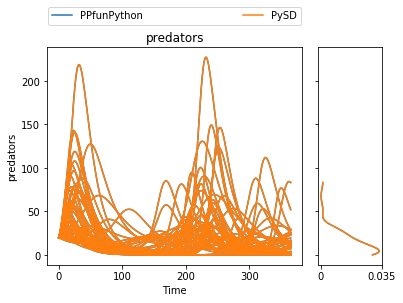

In [11]:
from ema_workbench.analysis import plotting, plotting_util, Density

lines(results[0], results[1], outcomes_to_show=['predators'], density = Density.KDE, group_by='model', experiments_to_show=np.arange(0, len(experiments), 1))
plt.show()

The PPfunPython is behind the PySD one!

We can also look at the differences between all of these implementations. Check the answers to look at how these can be done.